# 05 — Ethnicity Clusters from CLIP Embeddings

Goal:
- Use CLIP embeddings to discover **unsupervised ethnicity-like clusters**.
- Avoid unreliable built-in ethnicity outputs from InsightFace.
- Attach a stable `ethnicity_cluster` label to each image for use in:
  - statistics,
  - visualizations,
  - and composite generation.

Pipeline:
1. Load cleaned attributes from `../data/processed/metadata/attributes_clean.parquet`
2. Load CLIP embeddings for the same images.
3. Run K-Means clustering on embeddings.
4. Attach `ethnicity_cluster` to each row.
5. Save to `../data/processed/metadata/attributes_with_clusters.parquet`
   and optionally update `attributes_clean.parquet`.


In [1]:
import os
import numpy as np
import polars as pl
from sklearn.cluster import KMeans

# For quick sanity plots if you want them later
import matplotlib.pyplot as plt

# Paths (adjust EMBEDDINGS_PATH to match your actual file)
ATTR_PATH = "../data/processed/metadata/attributes_clean.parquet"

# TODO: set this to whatever 02_embeddings.ipynb actually wrote
# Examples (pick the one that matches your repo):
# EMBEDDINGS_PATH = "../data/processed/embeddings/clip_embeddings.parquet"
# EMBEDDINGS_PATH = "../data/processed/embeddings/clip_embeddings.npy"
EMBEDDINGS_PATH = "../data/processed/embeddings_clip.parquet"
# EMBEDDINGS_PATH = "/Users/jayklarin/__DI/Repositories/FaceStats/data/processed/embeddings/embeddings_clip.parquet"



In [2]:
import os

print("Current EMBEDDINGS_PATH:", EMBEDDINGS_PATH)
print("Exists? ->", os.path.exists(EMBEDDINGS_PATH))
print("Absolute Path:", os.path.abspath(EMBEDDINGS_PATH))

Current EMBEDDINGS_PATH: ../data/processed/embeddings_clip.parquet
Exists? -> True
Absolute Path: /Users/jayklarin/__DI/Repositories/FaceStats/data/processed/embeddings_clip.parquet


## Load Attributes & CLIP Embeddings

We load:
- `attributes_clean.parquet` (age, gender, ethnicity, etc.)
- CLIP embeddings generated in `02_embeddings.ipynb`

Then we join them on `filename`.


In [3]:
# Load cleaned attributes
df_attr = pl.read_parquet(ATTR_PATH)
df_attr.head()

filename,age,gender,ethnicity,face_count,confidence
str,f64,str,str,i64,f64
"""SFHQ_pt4_00000072.jpg""",81.0,"""female""","""Asian""",1,0.532229
"""SFHQ_pt4_00000090.jpg""",46.0,"""female""","""Asian""",1,0.526885
"""SFHQ_pt4_00000095.jpg""",30.0,"""female""","""Asian""",1,0.814608
"""SFHQ_pt4_00000182.jpg""",34.0,"""female""","""Asian""",1,0.696127
"""SFHQ_pt4_00000208.jpg""",50.0,"""female""","""Asian""",1,0.55539


In [4]:
if EMBEDDINGS_PATH.endswith(".parquet"):
    df_emb = pl.read_parquet(EMBEDDINGS_PATH)
    df_emb.head()
else:
    df_emb = None
    print("Parquet embeddings not loaded; EMBEDDINGS_PATH is not a .parquet file.")


In [5]:
# ---- Join Attributes + Embeddings ----

# Merge on filename
df = df_attr.join(df_emb, on="filename", how="inner")
print("Merged shape:", df.shape)
df.head()


Merged shape: (44, 7)


filename,age,gender,ethnicity,face_count,confidence,embedding
str,f64,str,str,i64,f64,list[f64]
"""SFHQ_pt4_00000208.jpg""",50.0,"""female""","""Asian""",1,0.55539,"[0.050459, -0.042498, … -0.011308]"
"""SFHQ_pt4_00003463.jpg""",41.0,"""female""","""Asian""",1,0.614588,"[0.049876, -0.015998, … 0.02997]"
"""SFHQ_pt4_00002219.jpg""",56.0,"""female""","""Asian""",1,0.737489,"[0.050927, -0.002582, … 0.014047]"
"""SFHQ_pt4_00003112.jpg""",41.0,"""female""","""Asian""",1,0.629827,"[0.021666, -0.005994, … -0.009105]"
"""SFHQ_pt4_00001507.jpg""",72.0,"""female""","""Asian""",1,0.585409,"[0.002976, -0.031937, … -0.054258]"


In [6]:
# ---- Convert embedding vectors to a NumPy matrix ----

import numpy as np

# Convert the list column "embedding" → 2D array
X = np.vstack(df["embedding"].to_list())
X.shape


(44, 512)

In [9]:
# Join attributes + embeddings on 'filename'
df_join = df_attr.join(df_emb, on="filename", how="inner")

print(df_join.shape)
df_join.head()


(44, 7)


filename,age,gender,ethnicity,face_count,confidence,embedding
str,f64,str,str,i64,f64,list[f64]
"""SFHQ_pt4_00000208.jpg""",50.0,"""female""","""Asian""",1,0.55539,"[0.050459, -0.042498, … -0.011308]"
"""SFHQ_pt4_00003463.jpg""",41.0,"""female""","""Asian""",1,0.614588,"[0.049876, -0.015998, … 0.02997]"
"""SFHQ_pt4_00002219.jpg""",56.0,"""female""","""Asian""",1,0.737489,"[0.050927, -0.002582, … 0.014047]"
"""SFHQ_pt4_00003112.jpg""",41.0,"""female""","""Asian""",1,0.629827,"[0.021666, -0.005994, … -0.009105]"
"""SFHQ_pt4_00001507.jpg""",72.0,"""female""","""Asian""",1,0.585409,"[0.002976, -0.031937, … -0.054258]"


In [10]:
from sklearn.decomposition import PCA

max_components = min(X.shape[0], 50)
pca = PCA(n_components=max_components, random_state=42)
X_pca = pca.fit_transform(X)
X_pca.shape


(44, 44)

In [13]:
from sklearn.cluster import KMeans
import polars as pl

N_CLUSTERS = 3  # adjust as needed

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_pca)

# Polars-safe assignment
df_join = df_join.with_columns(
    pl.Series("cluster", cluster_labels)
)

df_join.head()


filename,age,gender,ethnicity,face_count,confidence,embedding,cluster
str,f64,str,str,i64,f64,list[f64],i32
"""SFHQ_pt4_00000208.jpg""",50.0,"""female""","""Asian""",1,0.55539,"[0.050459, -0.042498, … -0.011308]",2
"""SFHQ_pt4_00003463.jpg""",41.0,"""female""","""Asian""",1,0.614588,"[0.049876, -0.015998, … 0.02997]",0
"""SFHQ_pt4_00002219.jpg""",56.0,"""female""","""Asian""",1,0.737489,"[0.050927, -0.002582, … 0.014047]",1
"""SFHQ_pt4_00003112.jpg""",41.0,"""female""","""Asian""",1,0.629827,"[0.021666, -0.005994, … -0.009105]",1
"""SFHQ_pt4_00001507.jpg""",72.0,"""female""","""Asian""",1,0.585409,"[0.002976, -0.031937, … -0.054258]",2


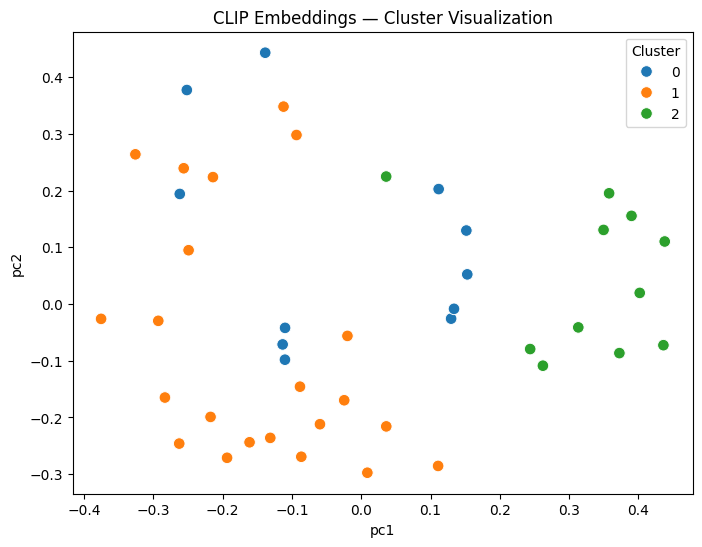

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reduce to 2D for visualization only
pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(X_pca)

df_vis = pd.DataFrame({
    "pc1": X_vis[:, 0],
    "pc2": X_vis[:, 1],
    "cluster": df_join["cluster"].to_list()
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_vis, x="pc1", y="pc2", hue="cluster", palette="tab10", s=70)
plt.title("CLIP Embeddings — Cluster Visualization")
plt.legend(title="Cluster")
plt.show()


In [16]:
# How many images per cluster?
df_join.group_by("cluster").count()


/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_48260/528750674.py:2: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  df_join.group_by("cluster").count()


cluster,count
i32,u32
1,22
0,11
2,11


In [19]:
# Aggregate by cluster
df_summary = df_join.group_by("cluster").agg([
    pl.count().alias("count"),
    pl.col("ethnicity").value_counts().alias("ethnicity_counts"),
    pl.col("gender").value_counts().alias("gender_counts"),
    pl.col("age").mean().alias("mean_age"),
    pl.col("age").median().alias("median_age"),
])
df_summary

/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_48260/380543664.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),


cluster,count,ethnicity_counts,gender_counts,mean_age,median_age
i32,u32,list[struct[2]],list[struct[2]],f64,f64
1,22,"[{""Asian"",22}]","[{""female"",22}]",36.045455,31.5
0,11,"[{""Asian"",11}]","[{""female"",11}]",50.636364,48.0
2,11,"[{""Asian"",11}]","[{""female"",11}]",54.363636,50.0


In [20]:
OUTPUT_CLUSTERED = "../data/processed/metadata/attributes_with_clusters.parquet"
df_join.write_parquet(OUTPUT_CLUSTERED)

print("Saved:", OUTPUT_CLUSTERED)


Saved: ../data/processed/metadata/attributes_with_clusters.parquet
